# Classification with Scikit-Learn's Support Vector Classifiers

The first section classifies a randomly generated 2D coordinates, and the second
section attempts to predict Pulsar stars.

`SVC`, `NuSVC` and `LinearSVC` are classes capable of performing binary and 
multi-class classification on a dataset.
- `SVC` and `NuSVC` are similar methods, but accept slightly different sets of 
parameters and have different mathematical formulations. 
- `LinearSVC` is a faster implementation of `SVC` for the case of a linear 
kernel. It lacks some of the attributes of `SVC` and `NuSVC`, like `support_`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

## Random Dataset

Generate a random dataset containing 1000 training examples belonging to 2 
classes - `0` and `1`. Each training example has 2 features, normally 
distributed around a center coordinate.

In [2]:
# Pick a center for each class
center_1 = np.array([0, 0])
center_2 = np.array([1, 1])

# Generate 500 data points around each center
data_1 = np.random.normal(loc=center_1, scale=(0.5, 0.3), size=(500, 2))
data_2 = np.random.normal(loc=center_2, scale=(0.3, 0.5), size=(500, 2))

# Create and concatenate the labels
labels_1 = np.zeros(500)
labels_2 = np.ones(500)
data1 = np.concatenate((data_1, labels_1.reshape(-1, 1)), axis=1)
data2 = np.concatenate((data_2, labels_2.reshape(-1, 1)), axis=1)

# Merge 2 classes and suffle
data = np.concatenate((data1, data2), axis=0)
np.random.shuffle(data)

train, test = train_test_split(data, test_size=0.2)

PLot the data points

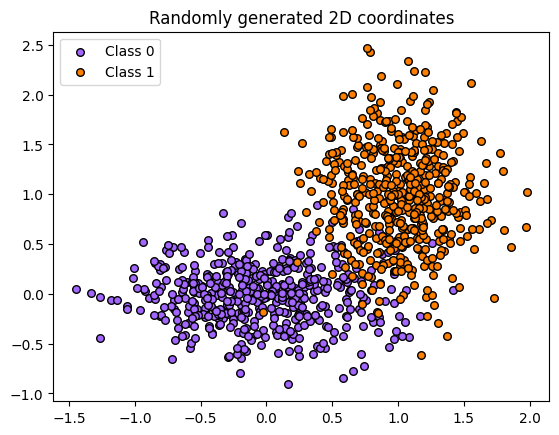

In [3]:
plt.scatter(data_1[:, 0], data_1[:, 1], s=30, c='#a366ff', edgecolors="k", label='Class 0')
plt.scatter(data_2[:, 0], data_2[:, 1], s=30, c='#ff8000', edgecolors="k", label='Class 1')
plt.title("Randomly generated 2D coordinates")
plt.legend()
plt.show()

### Train a RBF-kernel classifier on the random dataset

There are two parameters for an RBF kernel: $C$ and $\gamma$. A "grid-search" 
on $C$ and $\gamma$ validates various pairs of ($C$, $\gamma$) with the best 
cross-validation accuracy. 

We found that trying exponentially growing sequences of $C$ and $\gamma$ is a
practical method to identify good parameters:
- $C = 2^{-5}, 2^{-3}, \dots, 2^{15}$
- $\gamma = 2^{-15}, 2^{-13}, \dots, 2^{3}$

In [4]:
c_params = np.linspace(2 ** -5, 2 ** 15, 8)
g_params = np.linspace(2 ** -15, 2 ** 3, 8)
param_grid = { 'C': c_params, 'gamma': g_params }

svm_rbf = SVC(kernel='rbf')
grid_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5)
grid_rbf.fit(train[:, 0:2], train[:, 2])

best_params = grid_rbf.best_params_
best_score = grid_rbf.best_score_
print(f"Optimal parameters: {best_params}")
print(f"Validation score: {best_score}")

Optimal parameters: {'C': 9362.308035714286, 'gamma': 3.0517578125e-05}
Validation score: 0.9537500000000001


Visualize the search with heat map

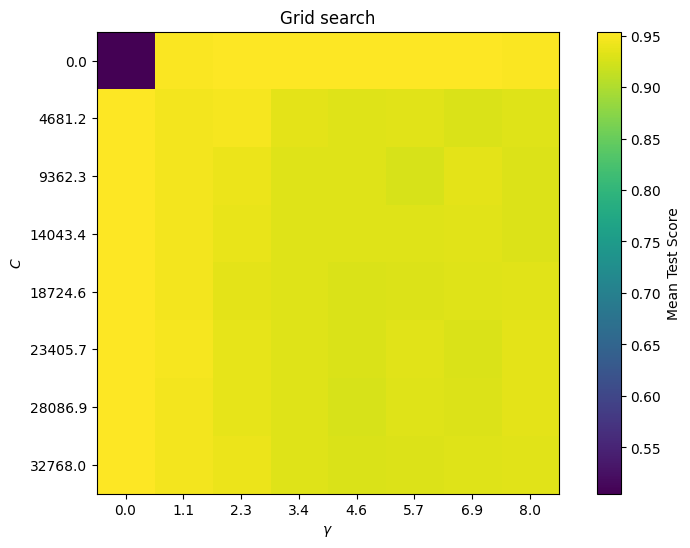

In [5]:
grid_score = np.array(grid_rbf.cv_results_['mean_test_score']).reshape(len(c_params), len(g_params))

plt.figure(figsize=(10, 6))
plt.imshow(grid_score, cmap='viridis')
plt.colorbar(label='Mean Test Score')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$C$')

c_param_str = np.vectorize(lambda x: '{:.1f}'.format(x))(c_params)
g_param_str = np.vectorize(lambda x: '{:.1f}'.format(x))(g_params)
plt.xticks(ticks=range(len(g_params)), labels=g_param_str)
plt.yticks(ticks=range(len(c_params)), labels=c_param_str)
plt.title('Grid search')
plt.show()

Train on the whole training set and compute the test accuracy

In [6]:
svm_rbf_optimal = grid_rbf.best_estimator_
svm_rbf_optimal.fit(train[:, 0:2], train[:, 2])
rbf_score = accuracy_score(test[:, 2], svm_rbf_optimal.predict(test[:, 0:2]))
print(f"RBF SVM test accuracy: {rbf_score}")

RBF SVM test accuracy: 0.975


Visualize the RBF decision boundary

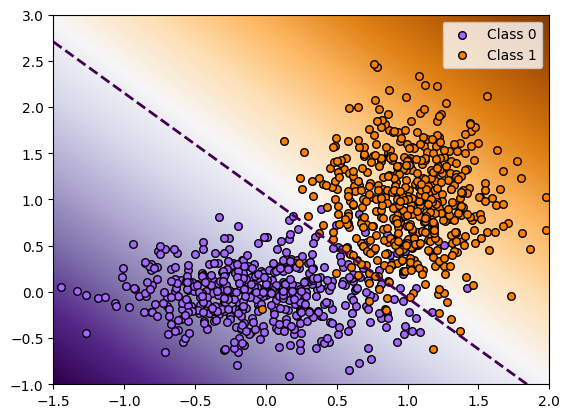

In [7]:
x_grid, y_grid = np.meshgrid(np.linspace(-1.5, 2, 500), np.linspace(-1, 3, 500))
z_grid = svm_rbf_optimal.decision_function(np.c_[x_grid.ravel(), y_grid.ravel()])
z_grid = z_grid.reshape(x_grid.shape)

plt.imshow(
    z_grid,
    interpolation="nearest",
    extent=(x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(x_grid, y_grid, z_grid, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(data_1[:, 0], data_1[:, 1], s=30, c='#a366ff', edgecolors="k", label='Class 0')
plt.scatter(data_2[:, 0], data_2[:, 1], s=30, c='#ff8000', edgecolors="k", label='Class 1')
plt.axis([-1.5, 2, -1, 3])
plt.legend()
plt.show()

### Train a linear classifier on the random dataset

For a linear SVM, there's only one parameter to vary: $C = 2^{2}, 2^{3}, 
\dots, 2^{15}$

In [8]:
c_params_linear = np.linspace(2 ** -5, 2 ** 15, 60)
param_grid = { 'C': c_params_linear }
svm_linear = SVC(kernel='linear')
grid_linear = GridSearchCV(estimator=svm_linear, param_grid=param_grid, cv=5)
grid_linear.fit(train[:, 0:2], train[:, 2])

best_params = grid_linear.best_params_
best_score = grid_linear.best_score_
print(f"Optimal parameters: {best_params}")
print(f"Validation score: {best_score}")

Optimal parameters: {'C': 0.03125}
Validation score: 0.9512499999999999


In [9]:
svm_linear_optimal = grid_linear.best_estimator_
svm_linear_optimal.fit(train[:, 0:2], train[:, 2])
linear_score = accuracy_score(test[:, 2], svm_linear_optimal.predict(test[:, 0:2]))
print(f"Linear SVM test accuracy: {linear_score}")

Linear SVM test accuracy: 0.975


Visualize the linear decision boundary

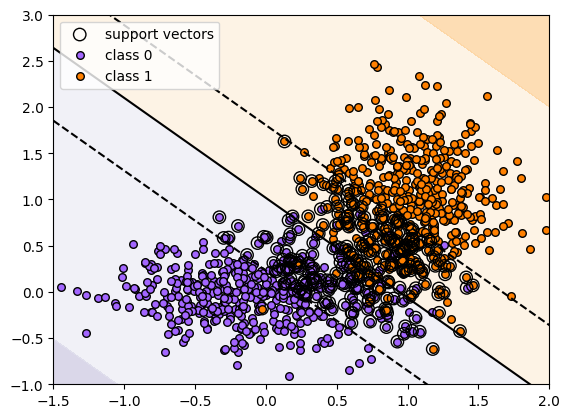

In [10]:
# Get the separating hyperplane
w_linear = svm_linear_optimal.coef_[0]
a_linear = -w_linear[0] / w_linear[1]
x_grid = np.linspace(-5, 5)
y_grid = a_linear * x_grid - (svm_linear_optimal.intercept_[0]) / w_linear[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.
margin = 1 / np.sqrt(np.sum(svm_linear_optimal.coef_**2))
y_grid_down = y_grid - np.sqrt(1 + a_linear ** 2) * margin
y_grid_up = y_grid + np.sqrt(1 + a_linear ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
plt.clf()
plt.plot(x_grid, y_grid, "k-")
plt.plot(x_grid, y_grid_down, "k--")
plt.plot(x_grid, y_grid_up, "k--")

plt.scatter(
    svm_linear_optimal.support_vectors_[:, 0],
    svm_linear_optimal.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    edgecolors="k",
    label="support vectors"
)

plt.axis("tight")
x_min = -1.5
x_max = 2
y_min = -1
y_max = 3

YY, XX = np.meshgrid(y_grid, x_grid)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_linear_optimal.decision_function(xy).reshape(XX.shape)

# Put the result into a contour plot
plt.contourf(XX, YY, Z, cmap=plt.cm.PuOr_r, alpha=0.5, linestyles=["-"])

plt.scatter(data_1[:, 0], data_1[:, 1], s=30, c='#a366ff', edgecolors="k", label='class 0')
plt.scatter(data_2[:, 0], data_2[:, 1], s=30, c='#ff8000', edgecolors="k", label='class 1')

plt.legend(loc='upper left')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

## Real Dataset

Pulsars are a rare type of Neutron star that produce radio emission detectable 
here on Earth. They are of considerable scientific interest as probes of space-
time, the interstellar medium, and states of matter. Machine learning tools are 
now being used to automatically label pulsar candidates to facilitate rapid 
analysis. In particular, classification systems are widely adopted, which treat 
the candidate datasets as binary classification problems.

The data is to be found with along to this notebook. The files are:
- `pulsar_data_train.csv` on which training and validation are performed.
- `pulsar_data_test.csv` on which test is performed.
The interest of having a separate 'test' file is that everybody can eveluate 
their model equialy. Competitions websites such as Kaggle keep there test 
dataset private to evaluate all participants' models on the same secrete data.

In [11]:
df_train = pd.read_csv("pulsar_data_train.csv")
df_test = pd.read_csv("pulsar_data_test.csv")
df_train.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [12]:
feature_names = [
    "profile_mean", "profile_std", "profile_kurtosis", "profile_skew", 
    "curve_mean", "curve_std", "curve_kurtosis", "curve_skew", "class"]
df_train.columns = feature_names
df_test.columns = feature_names
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   profile_mean      12528 non-null  float64
 1   profile_std       12528 non-null  float64
 2   profile_kurtosis  10793 non-null  float64
 3   profile_skew      12528 non-null  float64
 4   curve_mean        12528 non-null  float64
 5   curve_std         11350 non-null  float64
 6   curve_kurtosis    12528 non-null  float64
 7   curve_skew        11903 non-null  float64
 8   class             12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


In [13]:
data_train = df_train.drop('class', axis=1)
data_test = df_test.drop('class', axis=1)
label_train = df_train['class']

data_train.describe()

,profile_mean,profile_std,profile_kurtosis,profile_skew,curve_mean,curve_std,curve_kurtosis,curve_skew
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837


### Preporocess: missing values

The dataset contains many entries with missing values, suggesting the use of
imputation rather than simply discarding them.

In [14]:
print(f"Train entries count: {len(data_train)}")
na_count = len(data_train) - len(data_train.dropna())
print(f"Train entries containing NaNs: {na_count}")

print(f"Test entries count: {len(data_test)}")
na_count = len(data_test) - len(data_test.dropna())
print(f"Test entries containing NaNs: {na_count}")

Train entries count: 12528
Train entries containing NaNs: 3255
Test entries count: 5370
Test entries containing NaNs: 1385


In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_imputed = imputer.fit_transform(data_train.to_numpy())

data_imputed = pd.DataFrame(data_imputed, columns=feature_names[0:8])
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   profile_mean      12528 non-null  float64
 1   profile_std       12528 non-null  float64
 2   profile_kurtosis  12528 non-null  float64
 3   profile_skew      12528 non-null  float64
 4   curve_mean        12528 non-null  float64
 5   curve_std         12528 non-null  float64
 6   curve_kurtosis    12528 non-null  float64
 7   curve_skew        12528 non-null  float64
dtypes: float64(8)
memory usage: 783.1 KB


### Preprocess: rescaling values

Features of the Pulsar dataset have very different scales and contain 
potentially large outliers.

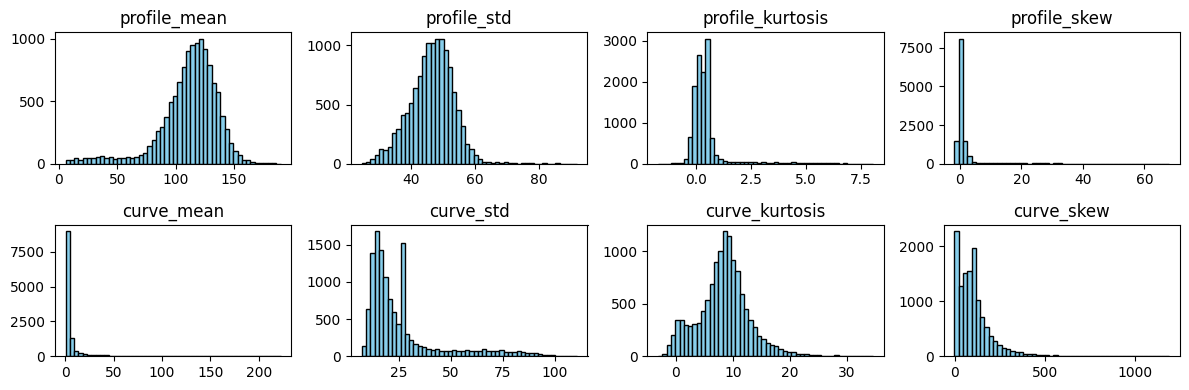

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(data_imputed.columns):
    ax = axes[i]
    ax.hist(data_imputed[col], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(col)

plt.tight_layout()
plt.show()

The `sklearn` package provides numerous types of scalers and transformers,
supporting both linear and non-linear scaling.
- `StandardScaler` removes the mean and scales the data to unit variance, cannot 
guarantee balanced feature scales in the presence of outliers.
- `MinMaxScaler` rescales the data set such that all feature values are in the 
range $[0, 1]$, very sensitive to the presence of outliers.
- `MaxAbsScaler` is similar to `MinMaxScaler` except that the values are mapped 
across several ranges depending on whether negative OR positive values are
present, also suffers from the presence of large outliers.
- The centering and scaling statistics of `RobustScaler` are based on 
percentiles and are therefore not influenced by a small number of very large 
marginal outliers.
- `PowerTransformer` applies a power transformation to each feature to make the 
data more Gaussian-like in order to stabilize variance and minimize skewness.
- `QuantileTransformer` applies a non-linear transformation such that the 
probability density function of each feature will be mapped to a uniform or 
Gaussian distribution. Contrary to `RobustScaler`, `QuantileTransformer` will 
also automatically collapse any outlier by setting them to the a priori defined 
range boundaries (0 and 1).
- `Normalizer` rescales the vector for each sample to have unit norm, 
independently of the distribution of the samples.

Since SVM favors a standardized dataset, we use the `RobustScaler` transform.

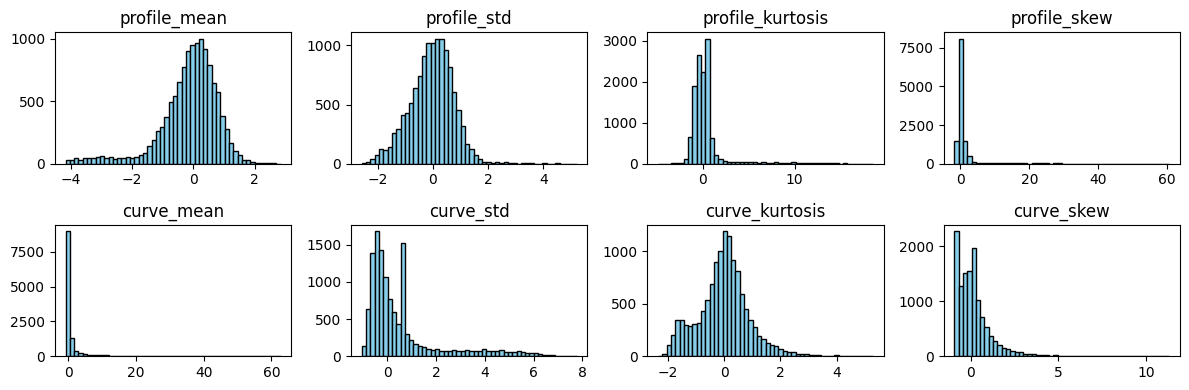

In [17]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=(25, 75))
data_scaled = scaler.fit_transform(data_imputed.to_numpy())

data_scaled = pd.DataFrame(data_scaled, columns=feature_names[0:8])

fig, axes = plt.subplots(2, 4, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(data_scaled.columns):
    ax = axes[i]
    ax.hist(data_scaled[col], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(col)

plt.tight_layout()
plt.show()

### Preprocess: unbalanced classes

The dataset is extremely unbalanced, with the number of samples belonging to 
class `0` ten times as many as that of `1`.

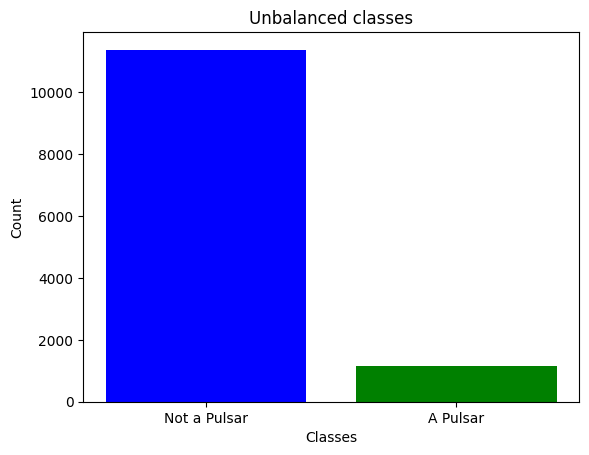

In [18]:
plt.bar([0, 1], [np.sum(label_train == 0), np.sum(label_train == 1)], color=['blue', 'green'])
plt.xticks([0, 1], ['Not a Pulsar', 'A Pulsar'])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Unbalanced classes')
plt.show()

We set the weight for class `1` ten times as much as for `0`.

In [19]:
class_weight = {1: 10}

### Training: grid search

We use the RBF kernel for this dataset because the number of samples outweights
the number of features by several orders of magnitude.

In [20]:
clf = SVC(kernel='rbf', class_weight=class_weight)

x_train = data_scaled.to_numpy()
y_train = label_train.to_numpy()
print(f"X shape: {x_train.shape}")
print(f"y shape: {y_train.shape}")

X shape: (12528, 8)
y shape: (12528,)


In [21]:
c_coarse = np.linspace(2 ** -5, 2 ** 15, 4)
g_coarse = np.linspace(2 ** -15, 2 ** 3, 4)
param_coarse = { 'C': c_coarse, 'gamma': g_coarse }

grid_coarse = GridSearchCV(estimator=clf, param_grid=param_coarse, cv=5, n_jobs=10)
grid_coarse.fit(x_train, y_train)

print(f"Optimal parameters (coarse): {grid_coarse.best_params_}")
print(f"Validation score (coarse) {grid_coarse.best_score_}")

Optimal parameters (coarse): {'C': 32768.0, 'gamma': 3.0517578125e-05}
Validation score (coarse) 0.9714241747948635


In [22]:
c_moderate = np.linspace(2 ** 14, 2 ** 16, 8)
g_moderate = np.linspace(2 ** -16, 2 ** -14, 8)
param_moderate = { 'C': c_moderate, 'gamma': g_moderate }

grid_moderate = GridSearchCV(estimator=clf, param_grid=param_moderate, cv=5, n_jobs=10)
grid_moderate.fit(x_train, y_train)

print(f"Optimal parameters (moderate): {grid_moderate.best_params_}")
print(f"Validation score (moderate) {grid_moderate.best_score_}")

Optimal parameters (moderate): {'C': 30427.428571428572, 'gamma': 6.103515625e-05}
Validation score (moderate) 0.9721427058094505


In [23]:
m_c = grid_moderate.best_params_['C']
c_dense = np.linspace(m_c - 10e3, m_c + 10e3, 16)
g_dense = np.linspace(2 ** -15, 2 ** -13, 16)
param_dense = { 'C': c_dense, 'gamma': g_dense }

grid_dense = GridSearchCV(estimator=clf, param_grid=param_dense, cv=5, n_jobs=10)
grid_dense.fit(x_train, y_train)

print(f"Optimal parameters (dense): {grid_dense.best_params_}")
print(f"Validation score (dense) {grid_dense.best_score_}")

Optimal parameters (dense): {'C': 33760.76190476191, 'gamma': 5.4931640625e-05}
Validation score (dense) 0.972302259009515


### Training: pipeline

The implementation incorporates `sklearn.pipeline` to streamline the preprocess 
steps in both final training and predicting.

In [24]:
best_estimator = grid_dense.best_estimator_
best_estimator.fit(x_train, y_train)

SVC(C=33760.76190476191, class_weight={1: 10}, gamma=5.4931640625e-05)

### Predict and export

It is important to keep the same transformer fitted to the training data when
predicting on the test set.

In [25]:
from sklearn.pipeline import make_pipeline

estimator = make_pipeline(imputer, scaler, best_estimator)

x_test = data_test.to_numpy()
y_pred = estimator.predict(x_test)

print(f"Number of positive predictions: {np.sum(y_pred == 1)}")

Number of positive predictions: 529


In [28]:
df_pred = pd.DataFrame(y_pred, columns=['y_pred'])
df_pred.to_csv('y_pred_test.csv', index=False)